# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Импорт библиотек**

In [1]:
# проверка версии sklearn
# import sklearn
# print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [2]:
# в работе использована опция поддерживаемая sklearn не ниже 0.23
# если в вашей системе использована более старая версия, пожалуйста обновите:
# pip install scikit-learn==0.23

In [3]:
import pandas as pd
import numpy as np

# настройка параметров отображения таблиц
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 100
pd.set_option("precision", 4)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# настройка окружения
sns.set_style("darkgrid", {'axes.grid' : True}) # задает темный фон и сетку на графиках
sns.set(palette='muted')

In [5]:
# загрузка библиотек sklearn
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
from IPython.display import display_html

## Загрузка и подготовка данных

In [7]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [8]:
# функция для вывода нескольких датафреймов рядом
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [9]:
# первое знакомство. оцениваем доступные данные "на глаз"
display_side_by_side(df_0.head(), df_1.head(), df_2.head())

,id,f0,f1,f2,product
0,txEyH,0.7057,-0.4978,1.2212,105.2801
1,2acmU,1.3347,-0.3402,4.3651,73.0378
2,409Wp,1.0227,0.1520,1.4199,85.2656
3,iJLyR,-0.0322,0.1390,2.9786,168.6208
4,Xdl7t,1.9884,0.1554,4.7518,154.0366
,id,f0,f1,f2,product
0,kBEdx,-15.0013,-8.2760,-0.0059,3.1791
1,62mP7,14.2721,-3.4751,0.9992,26.9533
2,vyE1P,6.2632,-5.9484,5.0012,134.7663
3,KcrkZ,-13.0812,-11.5061,4.9994,137.9454


In [10]:
# оценка пропусков и типов данных
# df_0.info()

**Пропусков в данных нет. Преобразование типов не требуется (проверено по всем трем датафреймам).**

In [11]:
# оценка диапазона значений данных
for df in [df_0, df_1, df_2]: 
     display(df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.5004,0.8718,-1.4086,-0.0726,0.5024,1.0736,2.3623
f1,100000.0,0.2501,0.5044,-0.8482,-0.2009,0.2503,0.7006,1.3438
f2,100000.0,2.5026,3.2482,-12.0883,0.2877,2.5160,4.7151,16.0038
product,100000.0,92.5000,44.2887,0.0000,56.4975,91.8500,128.5641,185.3643


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.1413,8.9659,-31.6096,-6.2986,1.1531,8.6210,29.4218
f1,100000.0,-4.7966,5.1199,-26.3586,-8.2680,-4.8132,-1.3328,18.7341
f2,100000.0,2.4945,1.7036,-0.0181,1.0000,2.0115,3.9999,5.0197
product,100000.0,68.8250,45.9444,0.0000,26.9533,57.0856,107.8130,137.9454


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.0020,1.7320,-8.7600,-1.1623,0.0094,1.1585,7.2383
f1,100000.0,-0.0021,1.7304,-7.0840,-1.1748,-0.0095,1.1637,7.8448
f2,100000.0,2.4951,3.4734,-11.9703,0.1304,2.4842,4.8588,16.7394
product,100000.0,95.0000,44.7499,0.0000,59.4504,94.9256,130.5950,190.0298


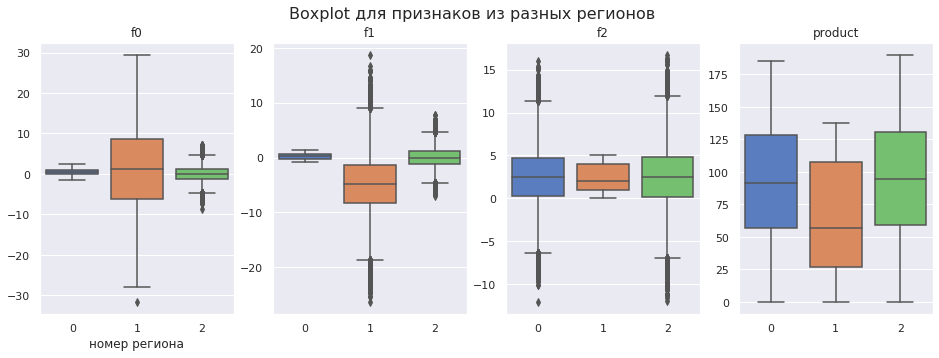

In [12]:
# оцениваем разброс признаков в данных с помощью boxplot
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
plt.suptitle('Boxplot для признаков из разных регионов', fontsize=16)
ax[0].set_title('f0'), ax[1].set_title('f1'), ax[2].set_title('f2'), ax[3].set_title('product')
sns.boxplot(data = [df_0['f0'], df_1['f0'], df_2['f0']], ax=ax[0])
sns.boxplot(data = [df_0['f1'], df_1['f1'], df_2['f1']], ax=ax[1])
sns.boxplot(data = [df_0['f2'], df_1['f2'], df_2['f2']], ax=ax[2]);
sns.boxplot(data = [df_0['product'], df_1['product'], df_2['product']], ax=ax[3])
ax[0].set_xlabel('номер региона');

Cредняя продуктивность скважин из регионов 0 и 2 выше, при этом разброс целевого признака очень велик - среднеквадратическое отклонение около 45 при среднем дебете 68-95 тыс.баррелей. У регионов 0 и 1 высокий разброс признака f2 и малый разброс для признаков f0 f1, для региона 1 - наоборот. 

<div class="alert alert-block alert-info">
<b>Совет: </b> В будущем для визуализации распределения советую использовать гистограммы.
</div>

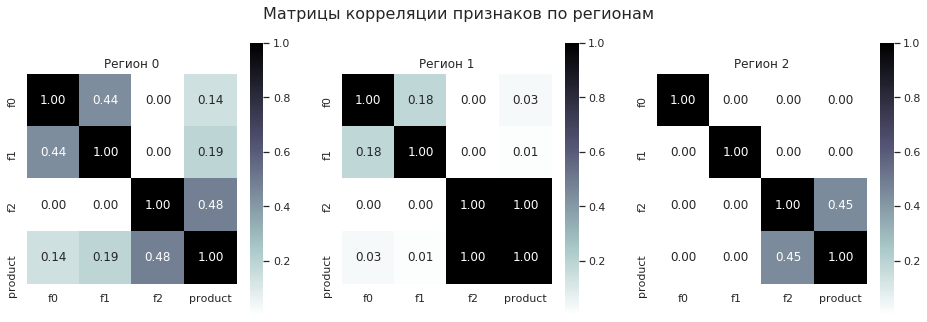

In [13]:
# проверяем корреляцию данных с целевым признаком и между собой
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
plt.suptitle('Матрицы корреляции признаков по регионам', fontsize=16)
ax[0].set_title('Регион 0'), ax[1].set_title('Регион 1'), ax[2].set_title('Регион 2')
for i, df in [ [0, df_0], [1, df_1], [2, df_2] ]:
    # используем абсолютное значение коэф. корреляции
    sns.heatmap(df.drop('id', axis=1).corr().abs(), annot=True, fmt='.2f', cmap='bone_r', square=True,  ax=ax[i]);

**Примечание:** Для наглядности матриц, при построении был отброшен знак у коэффициентов корреляции.\
И снова выделяется регион `1`. Есть очень сильная корреляция целевого признака и параметра `f2`: `коэф. корреляции = 1 !`. Для остальных регионов f2 также наиболее значим, коэф. на уровне 0.45 - 0.48. Остальные параметры больше коррелирую между собой чем с целевым признаком и только для региона `0`.

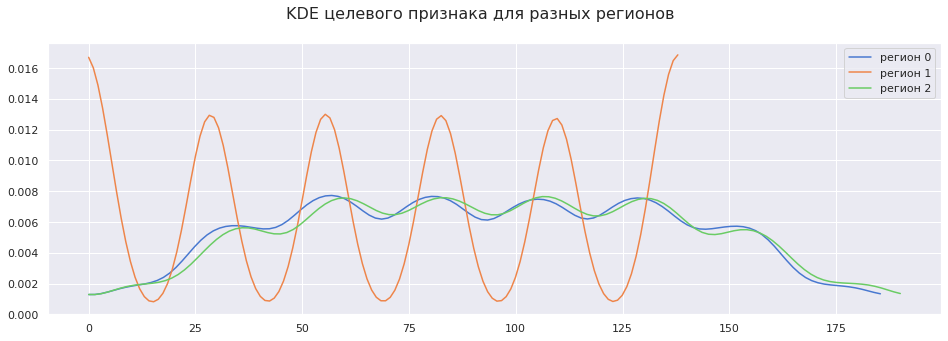

In [14]:
# построение KDE для целевого признака
# график поможет оценить частоту для определенных значений продуктивности скважин
fig = plt.figure(figsize=(16, 5))
plt.suptitle('KDE целевого признака для разных регионов', fontsize=16)
for df_for_kde in [df_0, df_1, df_2]:
    ax = sns.kdeplot(df_for_kde['product'], cut=0)
ax.legend(['регион 0', 'регион 1', 'регион 2']) ;   

**Вывод**\
Похоже данные для региона `1` полностью синтетические. Несмотря на большой размер выборки (100 000 значений) значения целевого признака сосредоточены только в нескольких узких диапазонах.  Однако, учитывая сильную корреляцию с признаком f2, модель для этого региона может оказаться наиболее точной.\
Характер кривой KDE целевого признака для других районов, также говорит о его отклонении от нормального распределения (Гаусса).

## Обучение и проверка модели

### Разбивка данных на обучающую и валидационную выборки

In [15]:
# функция для разделения на обучающую/тестовую выборки
# по умолчанию размер тестовой выборки 0.25
def train_test_split_mod(df, test_size=0.25):
    target = df['product']
    features = df.copy(deep=True).drop(['id', 'product'], axis=1)
    features_train, features_test, target_train, target_test = train_test_split(
            features, target, test_size=test_size, shuffle=True, random_state=210417)
    return (features_train, features_test, target_train, target_test)

In [16]:
# разбивка на обучающую/тестовую выборки по всем регионам
features_train_0, features_test_0, target_train_0, target_test_0 = train_test_split_mod(df_0)
features_train_1, features_test_1, target_train_1, target_test_1 = train_test_split_mod(df_1)
features_train_2, features_test_2, target_train_2, target_test_2 = train_test_split_mod(df_2)

In [17]:
# контроль размерности полученных выборок
# for df in [features_train_1, features_test_1, target_train_1, target_test_1]:
#     print (df.shape, end=' ')

### Обучение модели и предсказания на валидационной выборке.

Обучение моделей производилось разными алгоритмами регрессии: линейной и Grid/Lasso/Elastic с помощью ElasticNet. В итоге  оставлен вариант обычной линейной регрессии. Был проведен эксперимент с ElasticNet с параметрами штрафов дающими режим лассо и добавлены весовые коэффициенты. Идея состояла в том, чтобы повысить точность модели именно для скважин имеющих высокий показатель дебета. Точность оценки малопродуктивных скважи в нашем случае не так важна, поскольку согласно условиям задачи мы будем отбирать только 200 лучших сважин из выборки в 500. Добиться поставленной задачи в полной мере не удалось. Скорее всего из-за необходимости корректировать и оценку модели именно для целевого диапазона.

In [18]:
# Модель регрессии LinearRegression
# функция обучения модели линейной регрессии
# в соответствии с заданием при обучении используется метрика MSE
# для универсальности использовани GridSearchCV 
# при необходимости можно добавить гиперпараметры
# аргументы: features_train - признаки, target_train - целевой признак
# возвращает объект GridSearchCV
def grid_lr(features_train, target_train):
    model = LinearRegression()
    params = {} # словарь для перебора гиперпараметров
    grid = GridSearchCV(model, params, cv=2, scoring='neg_mean_squared_error')
    grid.fit(features_train, target_train)
    return grid

In [19]:
# Модель регрессии ElasticNet
def grid_elastic(features_train, target_train):
    model = ElasticNet(random_state=210417)
    # вариация параметра l1_ratio позволяет испытать разные модели штрафов: 
    # 0 - Grid, 1 - Lasso, и все промежуточные значения это Elastic
    params = {   'alpha': [1], 
                 'l1_ratio': [0.9, 0.99]                
} 
    
    grid = GridSearchCV(model, params, cv=2, scoring='neg_mean_squared_error')
    # добавлен параметр samle_weight чтобы повысить значимость образцов с высоким дебетом
    grid.fit(features_train, target_train, sample_weight= ((target_train / target_train.mean())))
    return grid

In [20]:
# линейная регрессия обучается быстро
# поэтому обучение всех моделей оставлено в одной ячейке
model_0 = grid_lr(features_train_0, target_train_0)
model_1 = grid_lr(features_train_1, target_train_1)
model_2 = grid_lr(features_train_2, target_train_2)

# вариант с обучением модели ElasticNet
# улучшения результата по сравнению с обычной линейной - нет
# model_0 = grid_elastic(features_train_0, target_train_0)
# model_1 = grid_elastic(features_train_1, target_train_1)
# model_2 = grid_elastic(features_train_2, target_train_2)

list_train = []
for model in [model_0, model_1,model_2]:
    list_train.append([*model.best_estimator_.coef_, np.sqrt(-model.best_score_)])
df_grid_result = pd.DataFrame(list_train, columns =['f0', 'f1', 'f2', 'RMSE_train'])
df_grid_result.index = ['region_0', 'region_1', 'region_2']
print('Результаты обучения линейной регрессии')
print('влияние отдельных признаков и метрика на обучающих данных')
df_grid_result

Результаты обучения линейной регрессии
влияние отдельных признаков и метрика на обучающих данных


,f0,f1,f2,RMSE_train
region_0,3.7573,-14.3414,6.5975,37.7369
region_1,-0.1450,-0.0214,26.9521,0.8890
region_2,-0.0687,0.0116,5.7477,40.0338


Предсказания сбылись, лучшая точность модели получена для региона 1. Признак f2 оказывает наибольшее влияние на целевой признак во всех моделях, кроме региона_0: там значимы все три признака.

### Предсказания и правильные ответы на валидационной выборке.

In [21]:
# функция создет датафрейм с признаками, с целевым признаком и предсказаниями
# (признаки оставлены для построения графиков)
# используется 'copy', чтобы сохранить структуру исходного датафрейма 'features'
def df_predicted(features, target, model):
    #df=pd.DataFrame()
    df = features.copy(deep=True) 
    df['target'] = target
    df['predicted'] = model.predict(features)
    return df

In [22]:
# создаем датафреймы с тестовыми данными с предсказаниями и 
df_predicted_0 = df_predicted(features_test_0, target_test_0, model_0) 
df_predicted_1 = df_predicted(features_test_1, target_test_1, model_1) 
df_predicted_2 = df_predicted(features_test_2, target_test_2, model_2) 

### Средний запас предсказанного сырья и RMSE модели.

In [23]:
# выводим метрики моделей для тестовых данных
list_predicted = []
for df in [df_predicted_0, df_predicted_1, df_predicted_2]:
    list_predicted.append([df.target.mean(), df.predicted.mean(), 
                           np.sqrt(mean_squared_error(df.target, df.predicted)),
                           r2_score(df.target, df.predicted)
                          ])
df_predicted = pd.DataFrame(list_predicted, columns =['mean_test', 'mean_predict', 'RMSE_test', 'R2_test'])
df_predicted.index = ['region_0', 'region_1', 'region_2']
df_predicted

,mean_test,mean_predict,RMSE_test,R2_test
region_0,92.5914,92.3196,37.5695,0.2777
region_1,68.5317,68.5183,0.8946,0.9996
region_2,95.7052,94.7121,40.1311,0.1967


### Графический анализ полученных моделей

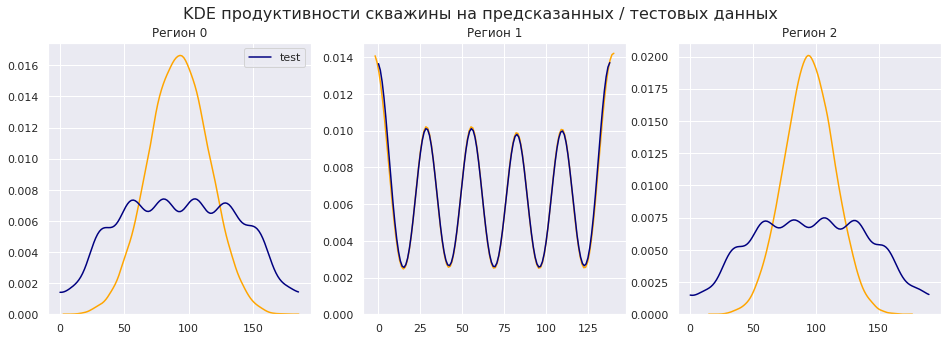

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
plt.suptitle('KDE продуктивности скважины на предсказанных / тестовых данных', fontsize=16)
ax[0].set_title('Регион 0'), ax[1].set_title('Регион 1'), ax[2].set_title('Регион 2')
sns.kdeplot(pd.Series(model_0.predict(features_test_0)), cut=0, ax=ax[0], color='orange')
sns.kdeplot(pd.Series(target_test_0), cut=0, ax=ax[0], color='navy');
ax[0].legend(['test', 'predicted'])
sns.kdeplot(pd.Series(model_1.predict(features_test_1)), cut=0, ax=ax[1], color='orange', legend=False)
sns.kdeplot(pd.Series(target_test_1), cut=0, ax=ax[1], color='navy', legend=False);

sns.kdeplot(pd.Series(model_2.predict(features_test_2)), cut=0, ax=ax[2], color='orange', legend=False)
sns.kdeplot(pd.Series(target_test_2), cut=0, ax=ax[2], color='navy', legend=False);

На графике KDE наглядно видна точность модели полученной для региона_1. Для остальных видно, что линейная модель дает нормальное распределение целевого признака, выраженный экстремум с занижением числа скважин на краях выборки имещих низкий и высокий дебет. Для региона_2 была использована модель Lasso с увеличенными весами для скважин с высокой продуктивностью, поэтому кривая предсказаний модели смещена вправо.

<div class="alert alert-block alert-info">
<b>Совет: </b> Даже на графиках видно, что для региона 2 мы построили не оптимальную модель, так как среднее желтого и синего графика не совпадает. На самом левом графике все ОК.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b>
    перевел все модели на линейную регрессию

In [25]:
# функция вывода графика распределения целевого признака по факторам f0, f1, f2
# для сравнения фактических и предсказанных данных
def show_target_predict(df, model=None):
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    plt.suptitle('Зависимость дебета скважин от факторов f0, f1, f2 для фактических/предсказанных данных', fontsize=16)
    for x, ax in ['f0', 0], ['f1', 1], ['f2', 2]:
        sns.scatterplot(data=df, x=x, y='product', ax=axes[ax], color='blue')
        if model is None:
            continue
        else:
            sns.scatterplot(data=df, x=x, y=model.predict(df.drop(['id', 'product'], axis=1)),
                        ax=axes[ax], color='orange', alpha=0.02)

Регион_0


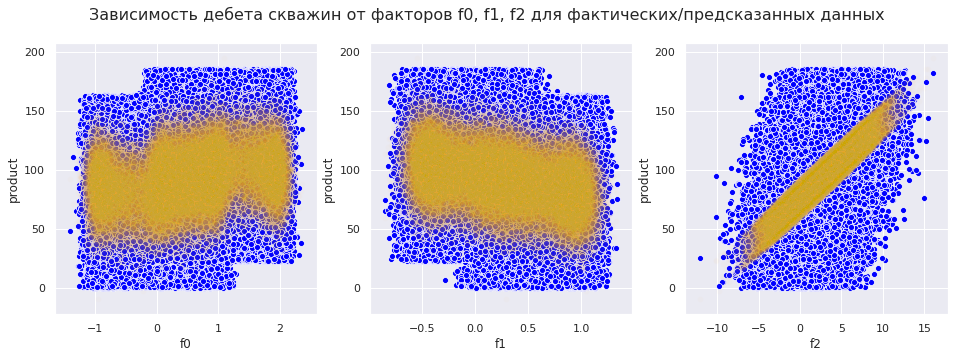

In [26]:
print('Регион_0')
show_target_predict(df_0, model_0) 

Регион_1


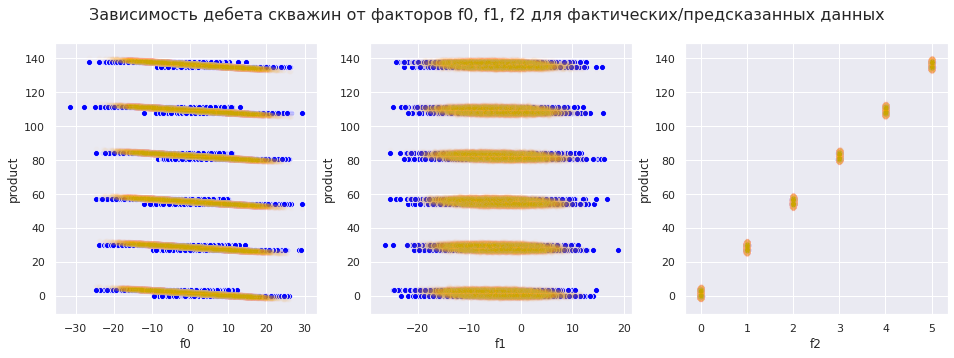

In [27]:
print('Регион_1')
show_target_predict(df_1, model_1)   

In [28]:
# print('Регион_2')
# show_target_predict(df_2, model_2) 

### Выводы

Данных много, но получить точную предсказательную модель удалось только для региона_1. Целевой признак имеет слабую корреляцию с параметрами, что затрудняет предсказания. Модели для региона_0 и региона_2 дают нормальное распределение целевого признака и большую ошибку по RMSE: около 40 при среднем занчении дебета скважин 92-94. Оптимальным выбором для прогнозорования стала модель линейной регрессии.\
Для качественного решения задачи этого проекта требуется смещенная оценка. Нам нужна высокая точность прогнозирования именно скважин с высоким дебетом, а не всего массива. Скорее всего нужен кастомный лосс штрафующий сильнее в области высоких значений, но пока отложено.

## Подготовка к расчёту прибыли

**Условия задачи:**\
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).\
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.\
Бюджет на разработку скважин в регионе — 10 млрд рублей.\
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.\
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

### Исходные данные

In [29]:
EXPLORATION_WELL = 500 # число разведочных скважин, шт.
WORKING_WELL = 200 # число скважин для бурения после отбора, шт.
GROSS_BUDGET = 10e9 # общий бюджет на бурение в одном районе, руб.
BARREL_PRICE = 450 # доход с одного барреля нефти, руб.

In [30]:
print('минимальное среднее количество продукта в месторождениях региона, достаточное для разработки')
print('{:.2f} тыс.баррелей'.format(GROSS_BUDGET / WORKING_WELL / (BARREL_PRICE * 1000)))

минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
111.11 тыс.баррелей


При заданных параметрах минимальный дебет скважины для выхода в безубыток - **111.11 тыс. баррелей.**

In [31]:
list=[]
for df in [df_0, df_1, df_2]:
    list.append(df['product'].mean())
df_mean = pd.DataFrame(list, columns=['mean'])
df_mean.index = ['region_0', 'region_1', 'region_2']
df_mean['min_for_profit'] = GROSS_BUDGET / WORKING_WELL / (BARREL_PRICE * 1000)
df_mean['delta'] = df_mean['mean'] - df_mean['min_for_profit']
df_mean

,mean,min_for_profit,delta
region_0,92.500,111.1111,-18.6111
region_1,68.825,111.1111,-42.2861
region_2,95.000,111.1111,-16.1111


Алгоритм расчета данный в инструкции к проекту расплывчат. Поэтому использован несколько иной подход: через бутстреп находится суммарный дебет отобранных скважин и полученные значения потом используются для расчета экономических показателей. Не хочется смешивать натуральные показатели и финансовые в рамках одной функции. Мы ведь обучали модель именно для прогнозирования дебета скважины, а не прогноза курса нефти на бирже.

Функция для расчета финансовых показателей разработки в **млн.руб.**

In [74]:
# функция определения фин. показателей разработки скважин региона (в млн.руб.)
# используется метод Bootstrap
# значения по умолчанию:
# - число разведочных скважин, шт.- exploration_well (500)
# - число скважин для бурения после отбора, шт.- working_well (200)
# - квантили отбора значений- quantile 2,5%

def oil_debt_sum(df, exploration_well=500, working_well=200, lower_quantile=0.025, upper_quantile=0.975):
    # для получения разнородных выборок вводится случайный параметр state для каждой выборки Bootstrap
    state = np.random.RandomState(131313)
    subsample = pd.DataFrame()
    values = []
    for i in range(1000):
        subsample = df.sample(n=exploration_well, replace=True, random_state=state)
        values.append(subsample.sort_values(by='predicted', ascending=False)['target'].head(working_well).sum())
    values = (pd.Series(values) * 1000 * BARREL_PRICE) - GROSS_BUDGET # определение прибыли для отобранных скважин
    values = values / 1000000 # перевод в млн. руб.
    # определяем точку безубыточности:
    # находим количество отрицательных значений в списке и делим на длину списка
    # это и даст нам необходимый квантиль, т.е. вероятность убытка
    
    # вывод нужных квантилей (сделано отдельными вызовами, чтобы получилось одним списком с точкой безубытка):
    return  (
            values.quantile(0.5),            # средняя прибыль
            values.quantile(lower_quantile), # нижний квантиль доверительного интервала           
            values.quantile(upper_quantile), # верхний квантиль доверительного интервала
            (len(values.loc[values < 0]) / len(values)) * 100 # расчет точки безубытка (вероятности в %)
    ) 

## Расчёт прибыли и рисков 

Рассчет экономических показателей добычи для разных регионов.

In [75]:
# расчет требуемых показателей прибыли
list = []
for df in [df_predicted_0, df_predicted_1, df_predicted_2]:
    list.append(oil_debt_sum(df))
df_profit = pd.DataFrame(list, columns = ['средняя_прибыль', 'нижн_граница', 'верх_граница', 'вероятность_убытка, %'])   
df_profit.index = ['region_0', 'region_1', 'region_2']
df_profit    

,средняя_прибыль,нижн_граница,верх_граница,"вероятность_убытка, %"
region_0,448.7680,-106.9083,931.8716,6.8
region_1,443.1343,65.9576,838.1701,1.2
region_2,422.2232,-65.8642,955.0156,5.7


## Общий вывод

**Условиям задачи соотвествует только регион_1.**
- За счет высокой точности построенной модели в регионе_1 можно можно отобрать сважины, которые обеспечат прибыль при риске до 2.5%. При этом регион_1 обладает самой низкой средней продуктивностью скважин - 65 тыс.баррелей (и 111,8 среди отобранных)
- При увеличении допустимого риска до 5,7% станет возможной и разработка региона_2, там более высокое среднее заначение запасов 95 тыс. баррелей и верхняя граница потенциальной прибыли, однако полученная модель пока не позволяет делать предсказания с необходимой точностью.